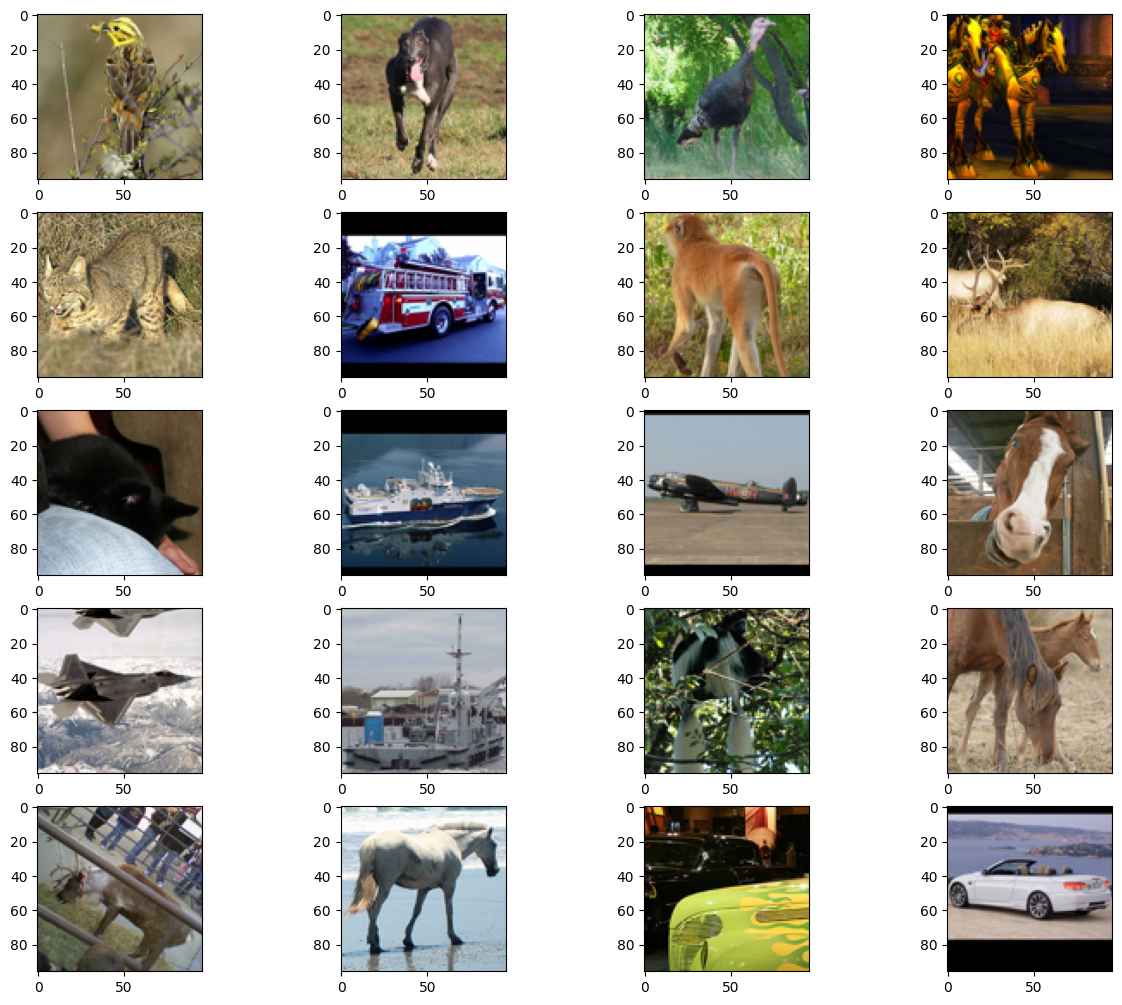

In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i, (img, _) in enumerate(data):
        if i == num_samples:
            break
        
        img = img.permute(1, 2, 0)
        # Convert the tensor to a NumPy array
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img)
data = torchvision.datasets.STL10(root='./data', download=True, transform=transform)
show_images(data)